In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score,
    classification_report
)



In [3]:
CSV_PATH = "DiaBD_A Diabetes Dataset for Enhanced Risk Analysis and Research in Bangladesh.csv"
df = pd.read_csv(CSV_PATH)

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (5288, 15)


,age,gender,pulse_rate,systolic_bp,diastolic_bp,glucose,height,weight,bmi,family_diabetes,hypertensive,family_hypertension,cardiovascular_disease,stroke,diabetic
0,42,Female,66,110,73,5.88,1.65,70.2,25.75,0,0,0,0,0,No
1,35,Female,60,125,68,5.71,1.47,42.5,19.58,0,0,0,0,0,No
2,62,Female,57,127,74,6.85,1.52,47.0,20.24,0,0,0,0,0,No
3,73,Male,55,193,112,6.28,1.63,57.4,21.72,0,0,0,0,0,No
4,68,Female,71,150,81,5.71,1.42,36.0,17.79,0,0,0,0,0,No


In [5]:
X = df.drop(columns=["diabetic"])
y = df["diabetic"].map({"No": 0, "Yes": 1})

print("Target Distribution:")
y.value_counts()



Target Distribution:


diabetic
0    4946
1     342
Name: count, dtype: int64

In [7]:
categorical_cols = ["gender"]
numeric_cols = [c for c in X.columns if c not in categorical_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Training Size:", X_train.shape)
print("Testing Size :", X_test.shape)


Training Size: (4230, 14)
Testing Size : (1058, 14)


In [11]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    ),
    "Gaussian Naive Bayes": GaussianNB()
}



In [13]:
def evaluate_model(name, estimator):
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", estimator)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    auc = None
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)

    print("\nModel:", name)
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    if auc is not None:
        print("ROC-AUC:", round(float(auc), 4))

    return pipe

trained_models = {}
for name, model in models.items():
    trained_models[name] = evaluate_model(name, model)




Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       990
           1       0.24      0.65      0.35        68

    accuracy                           0.84      1058
   macro avg       0.60      0.75      0.63      1058
weighted avg       0.93      0.84      0.87      1058

Confusion Matrix:
 [[847 143]
 [ 24  44]]
ROC-AUC: 0.8283

Model: Random Forest
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       990
           1       0.50      0.09      0.15        68

    accuracy                           0.94      1058
   macro avg       0.72      0.54      0.56      1058
weighted avg       0.91      0.94      0.91      1058

Confusion Matrix:
 [[984   6]
 [ 62   6]]
ROC-AUC: 0.8504

Model: Gaussian Naive Bayes
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       990
           1       0.27      0.43      0.3

In [15]:
best_model = trained_models["Logistic Regression"]

sample = X.iloc[[0]]
prediction = best_model.predict(sample)[0]

result = "Yes (Diabetic)" if prediction == 1 else "No (Non-diabetic)"

print("Sample Input:")
print(sample)
print("Prediction:", result)


Sample Input:
   age  gender  pulse_rate  systolic_bp  diastolic_bp  glucose  height  \
0   42  Female          66          110            73     5.88    1.65   

   weight    bmi  family_diabetes  hypertensive  family_hypertension  \
0    70.2  25.75                0             0                    0   

   cardiovascular_disease  stroke  
0                       0       0  
Prediction: No (Non-diabetic)


In [17]:
import matplotlib.pyplot as plt


In [19]:
results = []

for name, pipe in trained_models.items():
    y_pred = pipe.predict(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, zero_division=0)
    })

results_df = pd.DataFrame(results).set_index("Model")
results_df


,Accuracy,Precision,Recall,F1-Score
Model,,,,
Logistic Regression,0.842155,0.235294,0.647059,0.345098
Random Forest,0.935728,0.500000,0.088235,0.150000
Gaussian Naive Bayes,0.888469,0.268519,0.426471,0.329545


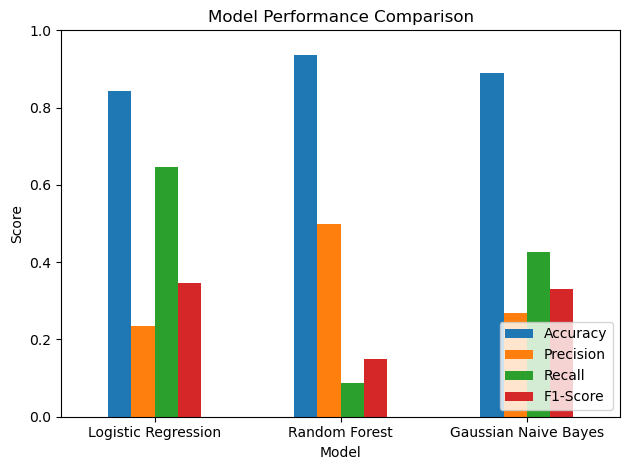

In [21]:
ax = results_df.plot(kind="bar", rot=0)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


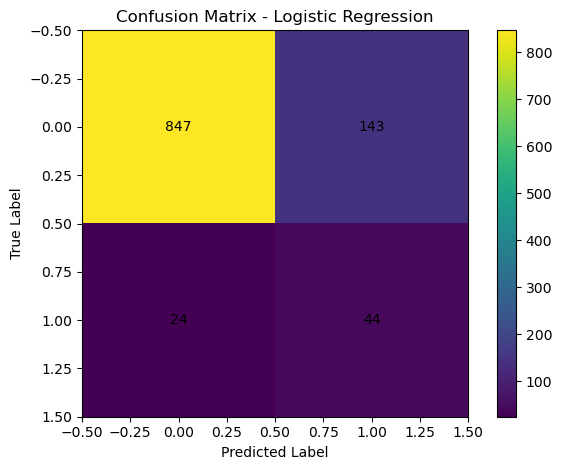

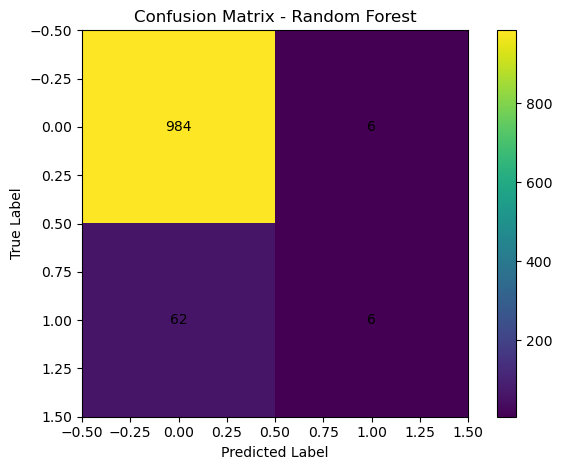

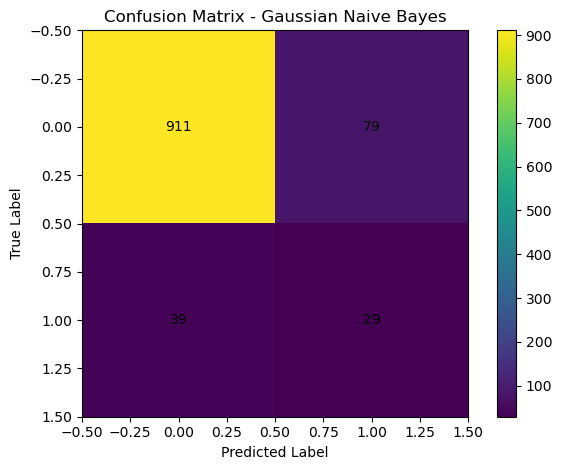

In [33]:
def plot_confusion(cm, title):
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")

    plt.tight_layout()
    plt.show()

for name, pipe in trained_models.items():
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion(cm, f"Confusion Matrix - {name}")


In [35]:
import ipywidgets as widgets
from IPython.display import display, clear_output

In [43]:
final_predict_model = trained_models["Logistic Regression"]

def ask_float(prompt, min_val=None, max_val=None):
    while True:
        try:
            val = float(input(prompt))
            if min_val is not None and val < min_val:
                continue
            if max_val is not None and val > max_val:
                continue
            return val
        except ValueError:
            pass

def ask_int01(prompt):
    while True:
        val = input(prompt).strip()
        if val in ["0", "1"]:
            return int(val)

def ask_gender(prompt):
    while True:
        val = input(prompt).strip().lower()
        if val in ["male", "m"]:
            return "Male"
        if val in ["female", "f"]:
            return "Female"

def run_diabetes_app():
    print("\nDIABETES RISK PREDICTION SYSTEM")
    print("Please enter patient details.")
    print("Note: For Yes/No questions → 0 = No, 1 = Yes\n")

    age = ask_float("Age (years): ", 1, 120)
    gender = ask_gender("Gender (Male/Female): ")

    pulse_rate = ask_float("Pulse rate (beats per minute): ", 20, 220)
    systolic_bp = ask_float("Systolic BP (mmHg): ", 50, 250)
    diastolic_bp = ask_float("Diastolic BP (mmHg): ", 30, 200)
    glucose = ask_float("Glucose level: ", 0)

    height = ask_float("Height (meters): ", 0.5, 2.5)
    weight = ask_float("Weight (kg): ", 10, 300)

    bmi = weight / (height ** 2)

    family_diabetes = ask_int01("Family history of diabetes? (0 = No, 1 = Yes): ")
    hypertensive = ask_int01("Patient is hypertensive? (0 = No, 1 = Yes): ")
    family_hypertension = ask_int01("Family history of hypertension? (0 = No, 1 = Yes): ")
    cardiovascular_disease = ask_int01("Cardiovascular disease present? (0 = No, 1 = Yes): ")
    stroke = ask_int01("History of stroke? (0 = No, 1 = Yes): ")

    user_data = pd.DataFrame([{
        "age": age,
        "gender": gender,
        "pulse_rate": pulse_rate,
        "systolic_bp": systolic_bp,
        "diastolic_bp": diastolic_bp,
        "glucose": glucose,
        "height": height,
        "weight": weight,
        "bmi": bmi,
        "family_diabetes": family_diabetes,
        "hypertensive": hypertensive,
        "family_hypertension": family_hypertension,
        "cardiovascular_disease": cardiovascular_disease,
        "stroke": stroke
    }])

    pred = int(final_predict_model.predict(user_data)[0])
    label = "Yes (Diabetic)" if pred == 1 else "No (Non-diabetic)"

    print("\nPrediction Result")
    print("Predicted Diabetes Status:", label)
    print("Calculated BMI:", round(bmi, 2))

    if hasattr(final_predict_model.named_steps["model"], "predict_proba"):
        prob = float(final_predict_model.predict_proba(user_data)[:, 1][0])
        print("Diabetes Risk Probability:", round(prob, 4))

run_diabetes_app()



DIABETES RISK PREDICTION SYSTEM
Please enter patient details.
Note: For Yes/No questions → 0 = No, 1 = Yes



Age (years):  50
Gender (Male/Female):  female
Pulse rate (beats per minute):  66
Systolic BP (mmHg):  110
Diastolic BP (mmHg):  73
Glucose level:  5.88
Height (meters):  1.65
Weight (kg):  70.2
Family history of diabetes? (0 = No, 1 = Yes):  0
Patient is hypertensive? (0 = No, 1 = Yes):  0
Family history of hypertension? (0 = No, 1 = Yes):  0
Cardiovascular disease present? (0 = No, 1 = Yes):  0
History of stroke? (0 = No, 1 = Yes):  0



Prediction Result
Predicted Diabetes Status: No (Non-diabetic)
Calculated BMI: 25.79
Diabetes Risk Probability: 0.206
